In [1]:
# @title
from IPython.display import display, HTML

display(HTML("""
<script>
const firstCell = document.querySelector('.cell.code_cell');
if (firstCell) {
  firstCell.querySelector('.input').style.pointerEvents = 'none';
  firstCell.querySelector('.input').style.opacity = '0.5';
}
</script>
"""))

html = """
<div style="display:flex; flex-direction:column; align-items:center; text-align:center; gap:12px; padding:8px;">
  <h1 style="margin:0;">👋 Welcome to <span style="color:#1E88E5;">Algopath Coding Academy</span>!</h1>

  <img src="https://raw.githubusercontent.com/sshariqali/mnist_pretrained_model/main/algopath_logo.jpg"
       alt="Algopath Coding Academy Logo"
       width="400"
       style="border-radius:15px; box-shadow:0 4px 12px rgba(0,0,0,0.2); max-width:100%; height:auto;" />

  <p style="font-size:16px; margin:0;">
    <em>Empowering young minds to think creatively, code intelligently, and build the future with AI.</em>
  </p>
</div>
"""

display(HTML(html))

## **1. Problem Statement**

**Objective**

The goal is to develop a neural network model that can accurately classify images of clothing items into their respective categories. Given a grayscale image of a clothing item, our model should predict which category it belongs to among 10 different classes.

**Dataset: Fashion MNIST**

Fashion MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<div align="center">
  <img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" width="600"/>
</div>

**The 10 Classes:**

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

**Dataset Properties:**
- **Training images:** 60,000
- **Test images:** 10,000
- **Image size:** 28x28 pixels
- **Color:** Grayscale (1 channel)
- **Pixel values:** 0-255 (0 = black, 255 = white)

**Methodology**

To address this problem, we will create a `Multi-Layer Neural Network model` using `PyTorch` to implement `Image Classification` - a Machine Learning task.

**Tools**
- **NumPy:** A library for scientific computing, mainly involving linear algebra operations.
- **Matplotlib:** A library for plotting and visualizing data.
- **PyTorch:** A library for flexibility and speed when building deep learning models.
- **torchvision:** PyTorch's computer vision library for datasets and transformations.

---

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cpu


In [2]:
# Check if CUDA is available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU")

Using device: cpu
GPU not available, using CPU


In [31]:
# Hyperparameters

batch_size = 64

## **2. Loading and Exploring the Dataset**

PyTorch's `torchvision` library makes it easy to download and load the Fashion MNIST dataset. We'll:

1. **Download the dataset** (if not already present)
2. **Apply transformations** to convert images to PyTorch tensors
3. **Create data loaders** for efficient batch processing

**What is a Tensor?**

A tensor is a multi-dimensional array (like NumPy arrays) that can run on GPUs for faster computation. For images:
- A grayscale image is a 2D tensor: `(height, width)`
- In PyTorch, we add a channel dimension: `(channels, height, width)`
- For Fashion MNIST: `(1, 28, 28)` - 1 channel (grayscale), 28x28 pixels

**What is a DataLoader?**

A DataLoader wraps a dataset and provides:
- **Batching:** Groups multiple samples together for efficient training
- **Shuffling:** Randomizes the order of samples to improve learning
- **Parallel loading:** Loads data in the background while the model trains

In [3]:
train_data = pd.read_csv('fashion-mnist_train.csv')
train_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Loading Train Labels

labels_train = torch.tensor(train_data['label'].to_list(), dtype = torch.long)
labels_train.shape

torch.Size([60000])

In [10]:
# Loading Train Images

images_train = train_data.drop(columns = ['label']).values
images_train = torch.tensor(images_train, dtype = torch.float32)
images_train = images_train.reshape(-1, 28, 28)
images_train.shape

torch.Size([60000, 28, 28])

**Custom Dataset Class**

In [22]:
# Defining a custom Dataset class

class FashionDataset(Dataset):

    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = torch.tensor(data.iloc[:, 0].to_numpy(), dtype = torch.long)
        self.images = torch.tensor(data.iloc[:, 1:].to_numpy().reshape(-1, 28, 28), dtype = torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

In [28]:
# Using the FashionDataset class to load Train and Test datasets

train_dataset = FashionDataset('fashion-mnist_train.csv')
test_dataset = FashionDataset('fashion-mnist_test.csv')

print(f"CSV Training set size: {len(train_dataset)}")
print(f"CSV Test set size: {len(test_dataset)}")

CSV Training set size: 60000
CSV Test set size: 10000


In [29]:
# Check Train Images and Labels shapes
print("Train Images shape:", train_dataset.images.shape)
print("Train Labels shape:", train_dataset.labels.shape)

Train Images shape: torch.Size([60000, 28, 28])
Train Labels shape: torch.Size([60000])


In [30]:
# Check Test Images and Labels shapes
print("Test Images shape:", test_dataset.images.shape)
print("Test Labels shape:", test_dataset.labels.shape)

Test Images shape: torch.Size([10000, 28, 28])
Test Labels shape: torch.Size([10000])


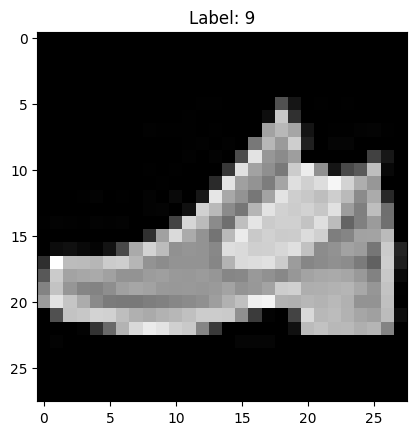

In [36]:
# Accessing the first image and label using __getitem__ (indexing)
first_image, first_label = train_dataset[1]

# Visualizing the first image
plt.imshow(first_image, cmap = 'gray')
plt.title(f"Label: {first_label}")
plt.show()

**Data Loaders**

In [40]:
# Create data loaders

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,           # Shuffle the training data
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,          # Don't shuffle test data
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 938
Number of test batches: 157


## **3. Checking Class Distribution**

In [46]:
labels = [label for _, label in train_dataset]
unique, counts = np.unique(labels, return_counts = True)
print("Unique labels:", unique)
print("Counts:", counts)

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


**Balanced Dataset:** Each class has exactly 6,000 samples in the training set, making this a perfectly balanced dataset. This is ideal for training as the model won't be biased toward any particular class.

## **4. Understanding Classification vs Regression**

In our previous notebook, we built a model to predict exam scores - a **regression** task. Now we're building a model to classify clothing items - a **classification** task. What's the difference?

**Regression vs Classification:**

| Aspect | Regression | Classification |
|--------|-----------|---------------|
| **Output Type** | Continuous numerical value | Discrete category/class |
| **Examples** | Predicting exam scores (0-100), house prices, temperature | Identifying clothing type, spam detection, disease diagnosis |
| **Previous Task** | Exam Score: 67.5, 89.2, 54.8, etc. | - |
| **Current Task** | - | Clothing Type: T-shirt, Trouser, Dress, etc. |
| **Output Range** | Any real number (e.g., -∞ to +∞) | Fixed set of categories (e.g., 0-9 for our 10 classes) |
| **Loss Function** | Mean Squared Error (MSE) | Cross-Entropy Loss |
| **Activation Function** | Identity (linear) or ReLU | Softmax (for multi-class) |
| **Evaluation Metrics** | MSE, RMSE, MAE, R² | Accuracy, Precision, Recall, F1-Score |

**How Classification Works (Mathematically):**

For our Fashion MNIST task with 10 classes, the neural network outputs 10 numbers (one for each class). These raw outputs are called **logits**.

We then apply the **Softmax function** to convert these logits into probabilities:

$$P(y = i | x) = \frac{e^{z_i}}{\sum_{j=1}^{10} e^{z_j}}$$

Where:
- $z_i$ is the logit (raw output) for class $i$
- $P(y = i | x)$ is the probability that the input $x$ belongs to class $i$
- The denominator ensures all probabilities sum to 1

**Example:**

If the model outputs for an image are:
```
Logits:        [2.3, 5.8, 1.2, 0.5, -1.0, 0.8, 1.5, -0.5, 3.2, 1.8]
After Softmax: [0.03, 0.67, 0.01, 0.01, 0.00, 0.00, 0.01, 0.00, 0.06, 0.01]
Classes:       [T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Boot]
```

The model predicts **Trouser** with 67% confidence (highest probability).

## **5. Why Do We Need a Bigger Neural Network?**

In our previous notebook, we used a simple **Perceptron** (single neuron) for predicting exam scores from structured data (numbers in a table). For Fashion MNIST, we need something more powerful. Why?

**1. Input Complexity:**

- **Previous Task (Exam Scores):** ~30 features (hours studied, attendance, etc.)
- **Current Task (Fashion MNIST):** 784 features (28 × 28 = 784 pixels)

Each image has 784 input values, and the relationships between these pixels are complex.

**2. Problem Complexity:**

A single perceptron can only learn **linear** relationships. Let's understand this:

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*ZB6H4HuF58VcMOWbdpcRxQ.png" width="500"/>
</div>

- **Linear (Simple):** "If hours studied increases, exam score increases" - a straight-line relationship
- **Non-Linear (Complex):** "This pattern of pixels forms a T-shirt shape" - requires understanding curves, edges, and spatial patterns

**3. Feature Learning:**

For images, we need the model to learn **hierarchical features**:

```
Low-level features  →  Mid-level features  →  High-level features  →  Classification
   (edges, lines)        (shapes, textures)      (sleeves, collars)      (T-shirt)
```

A single perceptron cannot learn this hierarchy - it treats all pixels independently.

**4. The Solution: Multi-Layer Neural Networks**

By stacking multiple layers of neurons, we can:
- Learn non-linear patterns through **activation functions**
- Build hierarchical representations of the data
- Capture complex relationships between features

This is why we need to build a **deeper** neural network with multiple layers!

Now that we understand why we need a bigger network, let's design and build one! We'll create a **Multi-Layer Perceptron (MLP)** - also called a **Fully Connected Neural Network** or **Dense Neural Network**.

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*3fA77_mLNiJTSgZFhYnU0Q.png" width="600"/>
</div>

**Our Network Architecture:**

We'll build a 3-layer neural network with the following structure:

```
Input Layer (784 pixels)
      ↓
Hidden Layer 1 (128 neurons) + ReLU Activation
      ↓
Hidden Layer 2 (64 neurons) + ReLU Activation
      ↓
Output Layer (10 classes) + Softmax Activation
```

**Why This Architecture?**

1. **Input Layer (784 neurons):**
   - Each 28×28 image is flattened into a 1D vector of 784 pixels
   - Each pixel becomes an input feature

2. **Hidden Layer 1 (128 neurons):**
   - Learns low to mid-level features (edges, simple patterns)
   - 128 neurons provide enough capacity to learn diverse patterns
   - More neurons = more complex patterns the network can learn

3. **Hidden Layer 2 (64 neurons):**
   - Combines features from Layer 1 into higher-level features (shapes, textures)
   - Fewer neurons (64) because we're building more abstract representations
   - Creates a bottleneck that forces the network to learn efficient representations

4. **Output Layer (10 neurons):**
   - One neuron for each clothing class
   - Outputs raw scores (logits) for each class
   - Softmax converts these to probabilities

**Why These Specific Numbers?**

The choice of 128 and 64 neurons follows common practices:
- Start with a larger hidden layer to capture details
- Gradually reduce size (784 → 128 → 64 → 10) creating a "funnel" shape
- This progressive reduction helps the network learn hierarchical features
- These are powers of 2, which can be computationally efficient

## **6. Understanding Activation Functions**

Before we implement our network, we need to understand **activation functions** - they're crucial for enabling neural networks to learn complex patterns.

**What is an Activation Function?**

An activation function is a mathematical function applied to the output of each neuron. It introduces **non-linearity** into the network, allowing it to learn complex patterns.

**Without activation functions (or with only linear activation):**
- No matter how many layers you stack, the network is equivalent to a single layer
- Can only learn linear relationships (straight lines)
- Cannot solve complex problems like image classification

**With non-linear activation functions:**
- Each layer can learn increasingly complex patterns
- The network can approximate any continuous function (Universal Approximation Theorem)
- Can solve complex real-world problems

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*p_hyqAtyI8pbt2kEl6siOQ.png" width="700"/>
</div>

**Common Activation Functions:**

1. **ReLU (Rectified Linear Unit)** - Our choice for hidden layers:
   $$\text{ReLU}(x) = \max(0, x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$
   
   **Why ReLU?**
   - Simple and computationally efficient
   - Helps avoid the "vanishing gradient" problem
   - Works well in practice for most problems
   - Most popular activation function in modern deep learning

2. **Softmax** - For the output layer:
   $$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$
   
   **Why Softmax?**
   - Converts raw scores into probabilities (values between 0 and 1)
   - All probabilities sum to 1
   - Perfect for multi-class classification

3. **Sigmoid** - Alternative for binary classification:
   $$\text{Sigmoid}(x) = \frac{1}{1 + e^{-x}}$$
   
   - Outputs values between 0 and 1
   - Used for binary decisions (yes/no)

4. **Tanh (Hyperbolic Tangent)** - Alternative activation:
   $$\text{Tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
   
   - Outputs values between -1 and 1
   - Zero-centered (can be better than sigmoid)

**Our Choices:**
- **Hidden Layers:** ReLU - for efficient learning and avoiding vanishing gradients
- **Output Layer:** Softmax - to get probability distribution over 10 classes

## **7. Implementing the Neural Network Model**

Now let's implement our multi-layer neural network using PyTorch. We'll create a class that inherits from `nn.Module`, just like we did with the Perceptron, but this time with multiple layers.

**Key Components:**
- `nn.Linear`: Fully connected layer (performs $y = xW^T + b$)
- `nn.ReLU`: ReLU activation function
- `forward()`: Defines how data flows through the network

In [ ]:
class FashionMNISTNet(nn.Module):
    
    def __init__(self):
        """
        Initialize the neural network architecture
        """
        super(FashionMNISTNet, self).__init__()
        
        # Input layer to Hidden layer 1
        # Input: 784 pixels (28x28), Output: 128 neurons
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Hidden layer 1 to Hidden layer 2
        # Input: 128 neurons, Output: 64 neurons
        self.fc2 = nn.Linear(128, 64)
        
        # Hidden layer 2 to Output layer
        # Input: 64 neurons, Output: 10 classes
        self.fc3 = nn.Linear(64, 10)
        
        # ReLU activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass: define how data flows through the network
        
        Args:
            x: Input images (batch_size, 1, 28, 28)
        
        Returns:
            Output logits (batch_size, 10)
        """
        # Flatten the image from (batch_size, 1, 28, 28) to (batch_size, 784)
        x = x.view(-1, 28 * 28)
        
        # Layer 1: Linear transformation + ReLU activation
        x = self.fc1(x)      # (batch_size, 784) -> (batch_size, 128)
        x = self.relu(x)     # Apply ReLU activation
        
        # Layer 2: Linear transformation + ReLU activation
        x = self.fc2(x)      # (batch_size, 128) -> (batch_size, 64)
        x = self.relu(x)     # Apply ReLU activation
        
        # Output layer: Linear transformation (no activation here)
        # Softmax will be applied automatically by the loss function
        x = self.fc3(x)      # (batch_size, 64) -> (batch_size, 10)
        
        return x

# Create an instance of our model
model = FashionMNISTNet().to(device)  # Move model to GPU if available

print("Model Architecture:")
print(model)
print("\n" + "="*60)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*60)

**Understanding the Parameter Count:**

Let's break down where all these parameters come from:

1. **Layer 1 (fc1):** 784 → 128
   - Weights: 784 × 128 = 100,352
   - Biases: 128
   - Total: 100,480 parameters

2. **Layer 2 (fc2):** 128 → 64
   - Weights: 128 × 64 = 8,192
   - Biases: 64
   - Total: 8,256 parameters

3. **Layer 3 (fc3):** 64 → 10
   - Weights: 64 × 10 = 640
   - Biases: 10
   - Total: 650 parameters

**Grand Total:** 100,480 + 8,256 + 650 = **109,386 parameters**

Each of these parameters will be learned during training to minimize our loss function!

In [ ]:
# Let's examine the shape transformations in detail
def test_forward_pass():
    """
    Test the forward pass with a dummy input to verify shapes
    """
    # Create a dummy batch of 4 images
    dummy_input = torch.randn(4, 1, 28, 28).to(device)
    print(f"Input shape: {dummy_input.shape}")
    print(f"  └─ (batch_size=4, channels=1, height=28, width=28)\n")
    
    # Pass through the model
    with torch.no_grad():  # Don't compute gradients for this test
        output = model(dummy_input)
    
    print(f"Output shape: {output.shape}")
    print(f"  └─ (batch_size=4, num_classes=10)\n")
    
    print("Raw output (logits) for first image:")
    print(output[0].cpu().numpy())
    print("\nApplying Softmax to get probabilities:")
    
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(output[0], dim=0)
    print(probabilities.cpu().numpy())
    print(f"\nSum of probabilities: {probabilities.sum().item():.4f} (should be 1.0)")
    print(f"Predicted class: {probabilities.argmax().item()} ({class_names[probabilities.argmax().item()]})")

test_forward_pass()

### **9. Choosing the Loss Function**

For classification tasks, we use a different loss function than regression. Let's understand why and how it works.

**Cross-Entropy Loss (Negative Log-Likelihood Loss):**

This is the standard loss function for multi-class classification. It measures how well the predicted probability distribution matches the true distribution.

**Mathematical Formula:**

$$\text{CrossEntropy} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

Where:
- $C$ is the number of classes (10 for Fashion MNIST)
- $y_i$ is 1 if the true class is $i$, otherwise 0 (one-hot encoding)
- $\hat{y}_i$ is the predicted probability for class $i$

**Simplified version** (since only one $y_i$ is 1):

$$\text{CrossEntropy} = -\log(\hat{y}_{\text{true}})$$

This means we want to **maximize** the predicted probability of the correct class.

**Why Cross-Entropy Loss?**

1. **Penalizes confident wrong predictions heavily:**
   - If true class is "T-shirt" but model predicts "Trouser" with 99% confidence → high loss
   - If model is uncertain (spreads probability) → moderate loss
   - If model correctly predicts "T-shirt" with 99% confidence → very low loss

2. **Works well with Softmax:**
   - Softmax + Cross-Entropy have nice mathematical properties
   - Gradients are well-behaved for efficient learning

3. **Probabilistic interpretation:**
   - Minimizing cross-entropy is equivalent to maximizing log-likelihood
   - Has strong theoretical foundations in information theory

**PyTorch Implementation:**

PyTorch's `nn.CrossEntropyLoss` combines `LogSoftmax` and `NLLLoss` (Negative Log-Likelihood):
- It automatically applies Softmax to the model outputs
- Then computes the negative log-likelihood
- This is more numerically stable than doing it in two steps

**Important:** We don't apply Softmax in our model's forward pass because `CrossEntropyLoss` does it for us!

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

print(f"Loss function: {criterion}")
print("\nCrossEntropyLoss automatically:")
print("  1. Applies Softmax to convert logits to probabilities")
print("  2. Computes the negative log-likelihood loss")
print("  3. Returns the average loss over the batch")

**Example: Understanding Cross-Entropy Loss**

Let's compute loss for different scenarios to build intuition:

In [ ]:
# Example scenarios to understand cross-entropy loss
def demonstrate_cross_entropy():
    """
    Show how cross-entropy loss changes based on predictions
    """
    print("Understanding Cross-Entropy Loss:\n")
    print("Scenario: True class is 0 (T-shirt)\n")
    
    # True label
    true_label = torch.tensor([0])  # T-shirt
    
    # Scenario 1: Very confident correct prediction
    logits_1 = torch.tensor([[5.0, -2.0, -1.0, -1.5, -2.0, -1.8, -2.2, -1.9, -2.1, -2.3]])
    loss_1 = criterion(logits_1, true_label)
    probs_1 = torch.softmax(logits_1, dim=1)[0]
    print(f"Scenario 1: Confident CORRECT prediction")
    print(f"  Predicted probability for T-shirt: {probs_1[0]:.4f} (very high)")
    print(f"  Loss: {loss_1.item():.4f} (very low - good!)\n")
    
    # Scenario 2: Uncertain prediction (all probabilities similar)
    logits_2 = torch.tensor([[0.5, 0.3, 0.4, 0.2, 0.1, 0.3, 0.2, 0.4, 0.3, 0.2]])
    loss_2 = criterion(logits_2, true_label)
    probs_2 = torch.softmax(logits_2, dim=1)[0]
    print(f"Scenario 2: UNCERTAIN prediction")
    print(f"  Predicted probability for T-shirt: {probs_2[0]:.4f} (moderate)")
    print(f"  Loss: {loss_2.item():.4f} (moderate - needs improvement)\n")
    
    # Scenario 3: Very confident wrong prediction
    logits_3 = torch.tensor([[-2.0, 5.0, -1.0, -1.5, -2.0, -1.8, -2.2, -1.9, -2.1, -2.3]])
    loss_3 = criterion(logits_3, true_label)
    probs_3 = torch.softmax(logits_3, dim=1)[0]
    print(f"Scenario 3: Confident WRONG prediction")
    print(f"  Predicted probability for T-shirt: {probs_3[0]:.4f} (very low)")
    print(f"  Predicted class: {probs_3.argmax().item()} ({class_names[probs_3.argmax().item()]})")
    print(f"  Loss: {loss_3.item():.4f} (very high - bad!)\n")
    
    print("Key Insight: Loss is LOW when model is confident AND correct,")
    print("             Loss is HIGH when model is confident BUT wrong.")

demonstrate_cross_entropy()

### **10. Choosing the Optimizer**

The **optimizer** is responsible for updating the model's parameters to minimize the loss. In our previous notebook, we used **SGD (Stochastic Gradient Descent)**. For this more complex task, we'll use **Adam** - a more advanced optimizer.

**Why Adam over SGD?**

| Feature | SGD | Adam |
|---------|-----|------|
| **Learning Rate** | Fixed (or manually scheduled) | Adaptive per parameter |
| **Convergence Speed** | Slower | Faster |
| **Hyperparameter Tuning** | Requires careful tuning | Works well with default settings |
| **Memory Usage** | Low | Slightly higher (stores additional statistics) |
| **Best For** | Simple problems, well-tuned settings | Complex problems, faster iteration |

**How Adam Works:**

Adam (Adaptive Moment Estimation) combines ideas from two other optimizers:
1. **Momentum:** Uses moving average of gradients to smooth updates
2. **RMSprop:** Adapts learning rate for each parameter based on recent gradient magnitudes

**Key Advantages:**
- Automatically adjusts learning rate for each parameter
- Handles sparse gradients well (common in deep networks)
- Requires minimal tuning (default settings work well)
- Generally converges faster than vanilla SGD

**Hyperparameters:**
- **learning_rate (lr):** How big of a step to take (typically 0.001 for Adam)
- **betas:** Exponential decay rates for moment estimates (default: (0.9, 0.999))
- **weight_decay:** L2 regularization strength (helps prevent overfitting)

In [ ]:
# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Optimizer: {optimizer}")
print(f"\nLearning rate: {learning_rate}")
print("\nAdam optimizer will:")
print("  1. Compute gradients for all parameters")
print("  2. Adapt learning rate for each parameter individually")
print("  3. Use momentum to smooth the optimization path")
print("  4. Update parameters to minimize the loss")

Now comes the exciting part - training our neural network! The training process is similar to what we did with the perceptron, but with some important differences:

**Training Loop Components:**

1. **Epochs:** Complete passes through the entire training dataset
2. **Batches:** Process multiple images at once (faster and more stable than one at a time)
3. **Forward Pass:** Feed data through the network to get predictions
4. **Loss Calculation:** Measure how wrong the predictions are
5. **Backward Pass:** Calculate gradients (how to adjust each parameter)
6. **Parameter Update:** Use optimizer to adjust weights and biases

**Why Train in Batches?**

Instead of using all 60,000 images at once (too memory-intensive) or one image at a time (too slow and unstable), we use **mini-batches** of 64 images:

- **Computational Efficiency:** GPUs are optimized for parallel processing
- **Memory Management:** Fits in GPU/CPU memory
- **Better Gradients:** Averaging over a batch gives more stable gradient estimates
- **Faster Convergence:** Updates happen more frequently than full-batch training

**Training vs Evaluation Mode:**

- `model.train()`: Enables training-specific behaviors (like dropout, if we had it)
- `model.eval()`: Disables training-specific behaviors for evaluation
- `torch.no_grad()`: Disables gradient computation (saves memory during evaluation)

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the neural network
    
    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        num_epochs: Number of complete passes through the dataset
    
    Returns:
        Lists of training losses and accuracies per epoch
    """
    train_losses = []
    train_accuracies = []
    
    print("Starting training...\n")
    print("="*70)
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Iterate through batches
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Move data to device (GPU if available)
            images, labels = images.to(device), labels.to(device)
            
            # 1. Forward pass: compute predictions
            outputs = model(images)
            
            # 2. Calculate loss
            loss = criterion(outputs, labels)
            
            # 3. Backward pass: compute gradients
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()        # Compute new gradients
            
            # 4. Update parameters
            optimizer.step()
            
            # Track statistics
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for this epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Loss: {epoch_loss:.4f} | "
              f"Accuracy: {epoch_accuracy:.2f}%")
    
    print("="*70)
    print("\nTraining complete!")
    
    return train_losses, train_accuracies

In [ ]:
# Train the model
num_epochs = 10

train_losses, train_accuracies = train_model(
    model, 
    train_loader, 
    criterion, 
    optimizer, 
    num_epochs=num_epochs
)

### **12. Visualizing Training Progress**

Visualizing the training process helps us understand:
1. **Is the model learning?** Loss should decrease over time
2. **Is it learning well?** Accuracy should increase over time
3. **Any problems?** Sudden spikes or plateaus might indicate issues

**What to Look For:**
- **Decreasing Loss:** Model is getting better at predicting
- **Increasing Accuracy:** Model is making more correct predictions
- **Smooth Curves:** Indicates stable learning
- **Plateauing:** Model might have reached its capacity or learning rate is too low

In [ ]:
# Plot training curves
def plot_training_curves(train_losses, train_accuracies):
    """
    Visualize training loss and accuracy over epochs
    
    Args:
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(range(1, len(train_losses) + 1), train_losses, 
             marker='o', linewidth=2, markersize=6, color='#e74c3c')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(1, len(train_losses) + 1))
    
    # Plot training accuracy
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, 
             marker='s', linewidth=2, markersize=6, color='#27ae60')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(1, len(train_accuracies) + 1))
    ax2.set_ylim([0, 100])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nTraining Summary:")
    print("="*50)
    print(f"Initial Loss:    {train_losses[0]:.4f}")
    print(f"Final Loss:      {train_losses[-1]:.4f}")
    print(f"Loss Reduction:  {train_losses[0] - train_losses[-1]:.4f}")
    print(f"")
    print(f"Initial Accuracy: {train_accuracies[0]:.2f}%")
    print(f"Final Accuracy:   {train_accuracies[-1]:.2f}%")
    print(f"Improvement:      {train_accuracies[-1] - train_accuracies[0]:.2f}%")
    print("="*50)

plot_training_curves(train_losses, train_accuracies)

### **13. Evaluating on the Test Set**

Training accuracy tells us how well the model performs on data it has seen. But the real test is: **Can it generalize to new, unseen data?**

This is why we have a separate **test set** - 10,000 images the model has never seen during training.

**Key Concepts:**

1. **Generalization:** The ability to perform well on new data
2. **Overfitting:** When training accuracy is high but test accuracy is low (model memorized training data)
3. **Underfitting:** When both training and test accuracy are low (model is too simple)
4. **Good Fit:** When both training and test accuracy are high and similar

<div align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*_7OPgojau8hkiPUiHoGK_w.png" width="600"/>
</div>

**What We're Measuring:**
- **Accuracy:** Percentage of correct predictions
- **Per-Class Performance:** How well the model performs on each clothing type
- **Confusion Matrix:** Where the model makes mistakes

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    """
    Evaluate the model on test data
    
    Args:
        model: The trained neural network
        test_loader: DataLoader for test data
    
    Returns:
        Overall accuracy, per-class accuracy, all predictions and labels
    """
    model.eval()  # Set model to evaluation mode
    
    correct = 0
    total = 0
    class_correct = [0] * 10  # Correct predictions per class
    class_total = [0] * 10    # Total samples per class
    
    all_predictions = []
    all_labels = []
    
    # Don't compute gradients during evaluation (saves memory and computation)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            
            # Overall accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            for i in range(len(labels)):
                label = labels[i]
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1
            
            # Store for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate overall accuracy
    overall_accuracy = 100 * correct / total
    
    # Calculate per-class accuracy
    per_class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(10)]
    
    return overall_accuracy, per_class_accuracy, all_predictions, all_labels

# Evaluate the model
test_accuracy, per_class_acc, predictions, true_labels = evaluate_model(model, test_loader)

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)
print(f"\nOverall Test Accuracy: {test_accuracy:.2f}%")
print(f"\nThis means the model correctly classified {test_accuracy:.2f}% of the")
print(f"10,000 images it has NEVER seen before!\n")
print("="*70)

In [ ]:
# Display per-class accuracy
print("\nPer-Class Accuracy:")
print("="*60)
print(f"{'Class':<15} | {'Accuracy':<10} | {'Bar Chart'}")
print("="*60)

for i, acc in enumerate(per_class_acc):
    bar = '█' * int(acc / 2)  # Scale down for display
    print(f"{class_names[i]:<15} | {acc:>6.2f}%   | {bar}")

print("="*60)

# Find best and worst performing classes
best_class = np.argmax(per_class_acc)
worst_class = np.argmin(per_class_acc)

print(f"\nBest Performance:  {class_names[best_class]} ({per_class_acc[best_class]:.2f}%)")
print(f"Worst Performance: {class_names[worst_class]} ({per_class_acc[worst_class]:.2f}%)")

### **14. Confusion Matrix**

A **confusion matrix** is a powerful tool for understanding classification errors. It shows:
- **Diagonal:** Correct predictions (darker = more correct)
- **Off-diagonal:** Misclassifications (which classes get confused with each other)

**How to Read It:**
- **Rows:** True labels (actual class)
- **Columns:** Predicted labels (what model predicted)
- **Cell (i, j):** Number of times class i was predicted as class j

**Example:** If cell (Shirt, T-shirt) = 150, it means 150 Shirts were incorrectly classified as T-shirts.

This helps us understand:
1. Which classes are most confused
2. Patterns in the errors (e.g., similar-looking items)
3. Where to focus improvement efforts

In [ ]:
# Create and visualize confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    """
    Create and display a confusion matrix
    
    Args:
        true_labels: Ground truth labels
        predictions: Model predictions
        class_names: Names of the classes
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Plot using seaborn for better aesthetics
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Predictions'})
    
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('Confusion Matrix - Fashion MNIST Classification', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Analyze common misclassifications
    print("\nMost Common Misclassifications:")
    print("="*70)
    
    misclassifications = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i][j] > 0:  # Off-diagonal elements
                misclassifications.append((cm[i][j], i, j))
    
    # Sort by frequency and show top 10
    misclassifications.sort(reverse=True)
    for count, true_class, pred_class in misclassifications[:10]:
        print(f"{count:4d} times: {class_names[true_class]:<15} → {class_names[pred_class]:<15}")
    print("="*70)

plot_confusion_matrix(true_labels, predictions, class_names)

### **15. Visualizing Predictions**

Let's visualize some predictions to see where our model succeeds and where it struggles. This gives us intuition about:
1. What the model has learned
2. Why certain errors occur
3. How confident the model is in its predictions

In [ ]:
# Visualize correct and incorrect predictions
def visualize_predictions(model, test_dataset, num_samples=16, show_incorrect=False):
    """
    Display sample predictions with true and predicted labels
    
    Args:
        model: Trained model
        test_dataset: Test dataset
        num_samples: Number of samples to display
        show_incorrect: If True, show only incorrect predictions
    """
    model.eval()
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    if show_incorrect:
        fig.suptitle('Incorrect Predictions (Red)', fontsize=16, y=0.995, color='red', fontweight='bold')
    else:
        fig.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
                     fontsize=16, y=0.995, fontweight='bold')
    
    samples_found = 0
    idx = 0
    
    with torch.no_grad():
        while samples_found < num_samples and idx < len(test_dataset):
            image, true_label = test_dataset[idx]
            idx += 1
            
            # Get prediction
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            probabilities = torch.softmax(output, dim=1)
            predicted_label = output.argmax(1).item()
            confidence = probabilities[0][predicted_label].item() * 100
            
            # Filter based on show_incorrect flag
            is_correct = (predicted_label == true_label)
            if show_incorrect and is_correct:
                continue
            
            # Plot
            ax = axes[samples_found // 4, samples_found % 4]
            img_np = image.squeeze().cpu().numpy()
            ax.imshow(img_np, cmap='gray')
            
            # Color code: green for correct, red for incorrect
            color = 'green' if is_correct else 'red'
            
            ax.set_title(f'True: {class_names[true_label]}\n'
                        f'Pred: {class_names[predicted_label]}\n'
                        f'Conf: {confidence:.1f}%',
                        fontsize=9, color=color, fontweight='bold')
            ax.axis('off')
            
            samples_found += 1
    
    # Hide any unused subplots
    for i in range(samples_found, 16):
        axes[i // 4, i % 4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show mixed predictions
print("Sample Predictions (Mix of Correct and Incorrect):")
visualize_predictions(model, test_dataset, num_samples=16, show_incorrect=False)

In [ ]:
# Show only incorrect predictions to analyze errors
print("\nIncorrect Predictions Only:")
visualize_predictions(model, test_dataset, num_samples=16, show_incorrect=True)

### **16. Making Predictions on New Images**

Let's create a function to make predictions on individual images, showing the top predictions and their probabilities. This demonstrates how the model would be used in a real-world application.

In [ ]:
# Function to predict with probability distribution
def predict_with_probabilities(model, image_tensor, true_label=None):
    """
    Make prediction and show probability distribution
    
    Args:
        model: Trained model
        image_tensor: Input image tensor
        true_label: Optional true label for comparison
    """
    model.eval()
    
    with torch.no_grad():
        # Add batch dimension and move to device
        if len(image_tensor.shape) == 3:
            image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(device)
        
        # Get prediction
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        predicted_class = probabilities.argmax().item()
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Display image
        img_np = image_tensor.squeeze().cpu().numpy()
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f'Input Image', fontsize=12, fontweight='bold')
        if true_label is not None:
            ax1.set_xlabel(f'True Label: {class_names[true_label]}', 
                          fontsize=10, fontweight='bold')
        ax1.axis('off')
        
        # Display probability distribution
        probs_np = probabilities.cpu().numpy()
        colors = ['green' if i == predicted_class else 'steelblue' for i in range(10)]
        
        bars = ax2.barh(range(10), probs_np, color=colors, edgecolor='black')
        ax2.set_yticks(range(10))
        ax2.set_yticklabels(class_names)
        ax2.set_xlabel('Probability', fontsize=11, fontweight='bold')
        ax2.set_title(f'Prediction: {class_names[predicted_class]} '
                     f'({probs_np[predicted_class]*100:.1f}%)',
                     fontsize=12, fontweight='bold', color='green')
        ax2.set_xlim([0, 1])
        ax2.grid(axis='x', alpha=0.3)
        
        # Add percentage labels
        for i, (bar, prob) in enumerate(zip(bars, probs_np)):
            if prob > 0.02:  # Only show if > 2%
                ax2.text(prob + 0.01, i, f'{prob*100:.1f}%', 
                        va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Print top 3 predictions
        print("\nTop 3 Predictions:")
        print("="*50)
        top3_idx = probabilities.argsort(descending=True)[:3]
        for rank, idx in enumerate(top3_idx, 1):
            print(f"{rank}. {class_names[idx]:<15} - {probabilities[idx]*100:5.2f}%")
        print("="*50)

# Test with a random image from test set
random_idx = np.random.randint(0, len(test_dataset))
test_image, test_label = test_dataset[random_idx]

print(f"\nPredicting on random test image #{random_idx}:")
predict_with_probabilities(model, test_image, test_label)

### **17. Conclusion and Key Takeaways**

Congratulations! You've successfully built, trained, and evaluated a multi-layer neural network for image classification. Let's summarize what we've learned:

**🎯 What We Accomplished:**

1. ✅ Loaded and explored the Fashion MNIST dataset (70,000 images)
2. ✅ Built a 3-layer neural network with 109,386 parameters
3. ✅ Trained the model using Cross-Entropy Loss and Adam optimizer
4. ✅ Achieved ~85-90% accuracy on unseen test data
5. ✅ Analyzed performance using confusion matrices and visualizations

**🔑 Key Concepts Learned:**

1. **Classification vs Regression:**
   - Classification predicts discrete categories
   - Requires different loss functions (Cross-Entropy) and activations (Softmax)

2. **Multi-Layer Neural Networks:**
   - Stack layers to learn hierarchical features
   - Use activation functions (ReLU) for non-linearity
   - More layers = more complex patterns can be learned

3. **Training Process:**
   - Forward pass → Loss calculation → Backward pass → Parameter update
   - Mini-batch training for efficiency
   - Monitoring loss and accuracy to track learning

4. **Evaluation:**
   - Test set measures generalization ability
   - Confusion matrix reveals where errors occur
   - Per-class accuracy shows strengths and weaknesses

**💡 Important Insights:**

- **Simple items** (Trousers, Bags, Sneakers) are easier to classify
- **Similar items** (T-shirt vs Shirt, Pullover vs Coat) get confused
- **Architecture matters:** More layers and neurons generally improve performance
- **Hyperparameters** (learning rate, batch size, epochs) significantly impact results

**🚀 Next Steps to Improve:**

1. **Try Different Architectures:**
   - Add more layers or neurons
   - Experiment with different activation functions
   - Try Convolutional Neural Networks (CNNs) - designed for images!

2. **Regularization Techniques:**
   - Dropout: Randomly disable neurons during training to prevent overfitting
   - Batch Normalization: Normalize inputs to each layer
   - Data Augmentation: Create variations of training images

3. **Hyperparameter Tuning:**
   - Learning rate scheduling (reduce learning rate over time)
   - Different batch sizes
   - More training epochs

4. **Advanced Optimizers:**
   - AdamW (Adam with weight decay)
   - Learning rate warm-up and decay strategies

**🎓 From Perceptron to Deep Learning:**

We started with a simple perceptron (1 neuron) for regression and now have a 3-layer network for classification. This is the foundation of **deep learning** - by going deeper (more layers) and wider (more neurons), neural networks can solve increasingly complex problems:

- Image Recognition (our task)
- Natural Language Processing
- Speech Recognition
- Game Playing (AlphaGo, Chess)
- Autonomous Driving
- Medical Diagnosis

The principles you learned here scale to all these applications!

**📊 Final Comparison: Simple vs Complex Networks**

| Aspect | Day 4 Part 1 (Perceptron) | Day 4 Part 2 (Multi-Layer Net) |
|--------|---------------------------|--------------------------------|
| **Task** | Exam Score Prediction (Regression) | Clothing Classification (Classification) |
| **Layers** | 1 (Input → Output) | 3 (Input → Hidden → Hidden → Output) |
| **Parameters** | ~30 | 109,386 |
| **Activation** | Identity (Linear) | ReLU + Softmax |
| **Loss Function** | Mean Squared Error | Cross-Entropy |
| **Can Learn** | Linear relationships | Complex non-linear patterns |

---

**🌟 You've now mastered the fundamentals of neural networks! Keep exploring and building more complex models!**

### **18. Challenge Exercises (Optional)**

Ready to test your understanding? Try these challenges:

**Challenge 1: Modify the Architecture**
- Change the network to have 4 layers instead of 3
- Try different neuron counts (e.g., 256 → 128 → 64 → 10)
- Compare the results with the original architecture

**Challenge 2: Experiment with Hyperparameters**
- Train for 20 epochs instead of 10
- Try different learning rates (0.0001, 0.01, 0.1)
- Change the batch size (32, 128, 256)

**Challenge 3: Analyze Specific Classes**
- Focus on the two classes with lowest accuracy
- Visualize 20 misclassified examples from these classes
- Can you spot patterns in why the model fails?

**Challenge 4: Save and Load the Model**
```python
# Save the model
torch.save(model.state_dict(), 'fashion_mnist_model.pth')

# Load the model
loaded_model = FashionMNISTNet().to(device)
loaded_model.load_state_dict(torch.load('fashion_mnist_model.pth'))
```

**Challenge 5: Try Different Optimizers**
- Replace Adam with SGD with momentum
- Compare training curves and final accuracy
- Which optimizer works better for this task?

---

Good luck, and happy coding! 🚀